## Sign Language -DL-AI

# Libraries :

In [41]:
import cv2
import tensorflow as tf
from keras.src.legacy.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam, SGD

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Implementation

In [2]:
def segmentation(frame, threshold=30):
    global background

    difference = cv2.absdiff(background.astype("uint8"), frame)

    _ , processed_frame = cv2.threshold(difference, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(processed_frame,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    else:
        contour = max(contours, key = cv2.contourArea)

    return (processed_frame, contour)

## Generate Dataset:

In [3]:
cam = cv2.VideoCapture(0)  

#roi => regin of interest
top=50
bottom=300
right =50
left =250

background = None
count = 0 
#Create Dataset
digit = 0
sample_num = 0

while True :
    value, frame = cam.read()
    frameCopy = frame.copy()
    frameCopy = cv2.flip(frame,1)
    roi = frameCopy[top:bottom, right:left]
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi_gray = cv2.GaussianBlur(roi_gray,(9,9),0)

    if background is None:
        background = roi_gray.copy().astype("float")
        
    
    cv2.rectangle(frameCopy, (left,top), (right,bottom),(0,0,255),3)
    
   
    
    
    if count < 30 :
        cv2.accumulateWeighted(roi_gray,background,0.5)
        cv2.putText(frameCopy, "Loading...",(280,200),cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,1.5,(255,255,255),3)

    collection  = segmentation(roi_gray)
    k = cv2.waitKey(1)
    if collection is not None:
         roi_processed, contour = collection
         cv2.drawContours(frameCopy,[contour+(right,top)],-1,(0,255,0),3)
         if k == ord(" "):
             cv2.putText(frameCopy, str(sample_num)+ " Gesture( "+str(digit)+" )",(70,45),cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,1,(255,255,255),2)
             cv2.imwrite("C:/Users/ASUS/Desktop/Real_time_Sign_Language_Detection/gesture/train/"+str(digit)+"/"+str(digit)+"-"+str(sample_num)+".jpg",roi_processed)

             sample_num+=1

        
         cv2.imshow("Segmention", roi_processed)

    cv2.putText(frameCopy, " Gesture( "+str(digit)+" )",(55,350),cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,1,(255,255,255),2)
    cv2.imshow("camera",frameCopy)
    count+=1
    k = cv2.waitKey(1)
    if k == 13:
        break
    elif k == 9:
        digit = (digit+1) % 11
        sample_num = 0
    
cv2.destroyAllWindows()
cam.release()


In [31]:
train_data_path = "C:/Users/ASUS/Desktop/Real_time_Sign_Language_Detection/gesture/train"
test_data_path = "C:/Users/ASUS/Desktop/Real_time_Sign_Language_Detection/gesture/test"


train_data_batches = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_data_path, target_size=(64,64),class_mode='categorical',batch_size=15,shuffle=True)
test_data_batches = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_data_path, target_size=(64,64),class_mode='categorical',batch_size=15,shuffle=True)


images_train, labels_train = next(train_data_batches)
images_test, labels_test = next(test_data_batches)

Found 863 images belonging to 11 classes.
Found 517 images belonging to 11 classes.


In [32]:
#cv2.imshow("test",images[0])
#cv2.waitKey(1)
#cv2.destroyAllWindows()
#labels[5]

def display(images):
    fig, axes = plt.subplots(1,15,figsize=(30,20))
    for image , ax in zip(images, axes):
        image = np.clip(image,0,1)
        ax.imshow(image)
        ax.axis('off')
    plt.tight_layout
    plt.show()


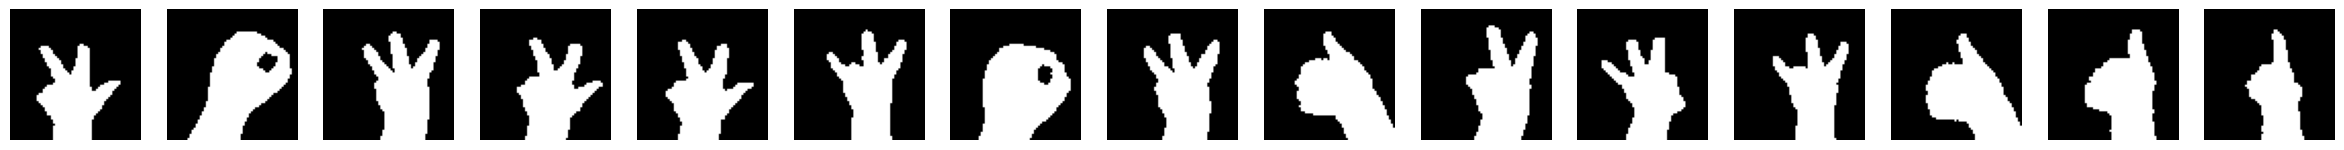

Three   Zero   Six   Three   Three   Seven   Zero   Six   Ten   Two   Nine   Seven   Ten   Ten   One   

(64, 64, 3)

In [33]:
words={0:'Zero',1:'One',2:'Two',3:'Three',4:'Four',5:'Five',6:'Six',7:'Seven',8:'Eight',9:'Nine',10:'Ten'}

display(images_test)
labels_test

def digits(labels):
    for label in labels:
        print(words[np.argmax(label)], end="   ")
digits(labels_test)

images_test[0].shape

## Create CNN Model :

In [34]:
#Convolutional Neural Network

def createModel():
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(64,64,3)))
    model.add(Conv2D(filters=32, kernel_size=(3,3) , activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=2))

    model.add(Conv2D(filters=64, kernel_size=(3,3) , activation='relu', padding= 'same'))
    model.add(MaxPool2D(pool_size=(2,2), strides=2))

    model.add(Conv2D(filters=128, kernel_size=(3,3) , activation='relu', padding= 'valid'))
    model.add(MaxPool2D(pool_size=(2,2), strides=2))

    model.add(Flatten())

    model.add(Dense(64,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(128,activation='relu'))

    model.add(Dense(11,activation='softmax'))

    return model



model = createModel()
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 31, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,475 (1.58 MB)

 Trainable params: 414,475 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

## Training CNN Model

In [42]:
model.compile(optimizer=SGD(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

reduceLR = ReduceLROnPlateau(monitor= 'val_loss' ,factor=0.2, patience=1,min_lr=0.0005)

early_stop = EarlyStopping(monitor= 'val_loss' ,min_delta=0, patience=1,mode='auto',verbose=0)

In [63]:
hist = model.fit(train_data_batches, epochs=10, callbacks=[reduceLR],validation_data=test_data_batches)

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9984 - loss: 0.0037 - val_accuracy: 0.9594 - val_loss: 0.1735 - learning_rate: 5.0000e-04
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9986 - loss: 0.0032 - val_accuracy: 0.9632 - val_loss: 0.1636 - learning_rate: 5.0000e-04
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 8.3549e-04 - val_accuracy: 0.9632 - val_loss: 0.1629 - learning_rate: 5.0000e-04
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9632 - val_loss: 0.1633 - learning_rate: 5.0000e-04
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 3.7792e-04 - val_accuracy: 0.9632 - val_loss: 0.1640 - learning_rate: 5.0000e-04
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9632 - val_loss: 0.1641 - learning_rate: 5.0000e-04
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy:

## Testing :

In [64]:
scores = model.evaluate(images_test, labels_test,verbose=0)
print(f'{model.metrics_names[0]} = {np.round(scores[0],1)} || {model.metrics_names[1]} = {scores[1] * 100}%')


loss = 0.0 || compile_metrics = 100.0%


In [65]:
model.save('C:/Users/ASUS/Desktop/Real_time_Sign_Language_Detection/model/SignLanguageModel.h5')

model2 = tf.keras.models.load_model('C:/Users/ASUS/Desktop/Real_time_Sign_Language_Detection/model/SignLanguageModel.h5')

In [70]:
cam = cv2.VideoCapture(0)  

#roi => regin of interest
top=50
bottom=300
right =50
left =250

background = None
count = 0 
#Create Dataset
digit = 0
sample_num = 0
model2 = tf.keras.models.load_model('C:/Users/ASUS/Desktop/Real_time_Sign_Language_Detection/model/SignLanguageModel.h5')

while True :
    value, frame = cam.read()
    frameCopy = frame.copy()
    frameCopy = cv2.flip(frame,1)
    roi = frameCopy[top:bottom, right:left]
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi_gray = cv2.GaussianBlur(roi_gray,(9,9),0)

    if background is None:
        background = roi_gray.copy().astype("float")
        
    
    cv2.rectangle(frameCopy, (left,top), (right,bottom),(0,0,255),3)
    
   
    
    
    if count < 30 :
        cv2.accumulateWeighted(roi_gray,background,0.5)
        cv2.putText(frameCopy, "Loading...",(280,200),cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,1.5,(255,255,255),3)

    collection  = segmentation(roi_gray)
    k = cv2.waitKey(1)
    if collection is not None:
         roi_processed, contour = collection
         cv2.drawContours(frameCopy,[contour+(right,top)],-1,(0,255,0),3)
       # /*****************/
         roi_processed = cv2.resize(roi_processed,(64,64))
         roi_processed = cv2.cvtColor(roi_processed,cv2.COLOR_GRAY2RGB)
         frame = np.reshape(roi_processed,(1,roi_processed.shape[0],roi_processed.shape[1],3))
         value = model2.predict(frame)
         label = words[np.argmax(value)]
         cv2.putText(frameCopy, str(label),(370,145),cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,2,(255,255,255),3)

         if k == ord(" "):
             cv2.putText(frameCopy, str(sample_num)+ " Gesture( "+str(digit)+" )",(70,45),cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,1,(255,255,255),2)
             cv2.imwrite("C:/Users/ASUS/Desktop/Real_time_Sign_Language_Detection/gesture/train/"+str(digit)+"/"+str(digit)+"-"+str(sample_num)+".jpg",roi_processed)

             sample_num+=1

        
         cv2.imshow("Segmention", roi_processed)

    cv2.putText(frameCopy, " Gesture( "+str(digit)+" )",(55,350),cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,1,(255,255,255),2)
    cv2.imshow("camera",frameCopy)
    count+=1
    k = cv2.waitKey(1)
    if k == 13:
        break
    elif k == 9:
        digit = (digit+1) % 11
        sample_num = 0
    
cv2.destroyAllWindows()
cam.release()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━